In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
name = 'twitter15'

In [35]:
df_train = pd.read_csv(f'seiz_dataset_{name}.csv')
df_val = pd.read_csv(f"seiz_dataset_{name}_val.csv")

In [102]:
df_train.shape

(994, 14)

In [36]:
init_pops = ['S0', 'E0', 'I0', 'Z0']

In [37]:
def transform_seiz_data(input_data):
    #Computing R score
    df = input_data.copy()
    p = df.p.values
    beta = df.beta.values
    l = df.l.values
    rho = df.rho.values
    epsilon = df.epsilon.values
    b = df.b.values
    df['R'] = ((1 - p) * beta + (1 - l) * b) / (rho + epsilon)
    # Normalizing population columns
    df['N'] = df[init_pops].values.sum(1)
    for col in init_pops:
        df[col] = df[col].values / df['N'].values
    df = df.drop(columns='N')
    #Incubation time is relevant
    df['incubation_time'] = 1 / df.epsilon.values
    #Encode target as category for lightgbm
    encoder = {"true":0, "false":1, "non-rumor":2, "unverified":3}
    df.label = df.label.apply(lambda x: encoder[x])
    return df

In [38]:
df_train = transform_seiz_data(df_train)
df_val = transform_seiz_data(df_val)

### Experimenting with LighGbm

In [93]:
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score

In [94]:
gbm_model = GradientBoostingModel(ntrees=1000, lr=0.01, max_d=5, feature_fraq=1.0)

In [95]:
dataset = lgb.Dataset(df_train.iloc[:, 1:], label=df_train.label)
dataset.construct()
params = {
    'objective':'multiclass',
    'num_class':4,
    'bagging_freq':5,
    'feature_fraction':1.0,
    'boosting_type':'gbdt',
    'max_depth':5,
    'learning_rate':0.01,
    'n_estimators':1000,
    'verbosity':2
    }
gbm_model = lgb.train(params, train_set=dataset)

/home/arnaud15/miniconda3/envs/snap/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [96]:
preds = gbm_model.predict(df_val.iloc[:, 1:], raw_score=False).argmax(1)

In [97]:
accuracy_score(df_val.iloc[:, 0].values, preds)

0.4527027027027027

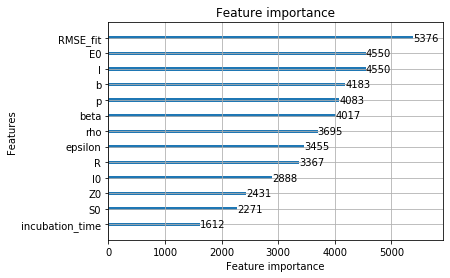

In [98]:
lgb.plot_importance(gbm_model)

### Trying out a MLP

In [271]:
import torch
import torch.nn as nn

In [299]:
n_hidden_layers = 3
hidden_size = 64
batch_size = 64
lr = 0.0001
dropout_prob =0.2
n_epochs = 10000

In [300]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [301]:
model_seq = [nn.BatchNorm1d(num_features=13, affine=False)]
model_seq.append(nn.Linear(in_features=13, out_features=hidden_size))
for _ in range(n_hidden_layers):
    model_seq.append(nn.Dropout(dropout_prob))
    model_seq.append(nn.Linear(in_features=hidden_size, out_features=hidden_size))
model_seq.append(nn.Linear(in_features=hidden_size, out_features=4))
mlp = nn.Sequential(*model_seq)
mlp = mlp.to(device)

In [302]:
optim = torch.optim.Adam([param for name, param in mlp.named_parameters()], lr=lr)

In [303]:
train_loader = torch.utils.data.DataLoader(df_train.values, batch_size=batch_size, shuffle=True)
test_loader = train_loader

In [304]:
loss_func = nn.CrossEntropyLoss(reduction='mean')
for epoch in range(n_epochs):
    epoch_loss = 0.
    
    #TRAIN
    mlp.train()
    for dp in train_loader:
        y = dp[:, 0].to(device).long()
        x = dp[:, 1:].to(device).float()
        logits = mlp(x)

        
        loss = loss_func(logits, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Mean Loss = {epoch_loss/len(train_loader):.3f}")
        
    
    #EVAL
    mlp.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for dp in test_loader:
            y = dp[:, 0].to(device).long()
            x = dp[:, 1:].to(device).float()
            logits = mlp(x)
            _, preds = logits.max(dim=1)
            correct += float(preds.eq(y).sum().item())
            total += y.size(0)
    if (epoch+1) % 10 == 0:
        print(f"Accuracy Epoch {epoch+1}: {correct/total:.3f}")

Epoch 10: Mean Loss = 1.343
Accuracy Epoch 10: 0.356
Epoch 20: Mean Loss = 1.324
Accuracy Epoch 20: 0.353
Epoch 30: Mean Loss = 1.329
Accuracy Epoch 30: 0.350
Epoch 40: Mean Loss = 1.325
Accuracy Epoch 40: 0.348
Epoch 50: Mean Loss = 1.329
Accuracy Epoch 50: 0.353
Epoch 60: Mean Loss = 1.331
Accuracy Epoch 60: 0.350
Epoch 70: Mean Loss = 1.319
Accuracy Epoch 70: 0.352
Epoch 80: Mean Loss = 1.328
Accuracy Epoch 80: 0.355
Epoch 90: Mean Loss = 1.322
Accuracy Epoch 90: 0.349
Epoch 100: Mean Loss = 1.324
Accuracy Epoch 100: 0.349
Epoch 110: Mean Loss = 1.324
Accuracy Epoch 110: 0.349
Epoch 120: Mean Loss = 1.318
Accuracy Epoch 120: 0.351
Epoch 130: Mean Loss = 1.322
Accuracy Epoch 130: 0.349
Epoch 140: Mean Loss = 1.321
Accuracy Epoch 140: 0.348
Epoch 150: Mean Loss = 1.326
Accuracy Epoch 150: 0.351
Epoch 160: Mean Loss = 1.320
Accuracy Epoch 160: 0.350
Epoch 170: Mean Loss = 1.309
Accuracy Epoch 170: 0.358
Epoch 180: Mean Loss = 1.322
Accuracy Epoch 180: 0.353
Epoch 190: Mean Loss = 1.321

KeyboardInterrupt: 